<a href="https://colab.research.google.com/github/Mdasiftalukdar/Sentiment-Analysis-on-different-dataset-using-machine-learning-classifiers/blob/main/Sentiment_Analysis_on_different_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Loading libraries**

In [26]:

#Data manipulation 
import re
import string
import pandas as pd
import numpy as np

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud 
from wordcloud import WordCloud, ImageColorGenerator

#metrics
from sklearn.metrics import f1_score , recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, classification_report

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

#Classifiers 
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC

# Time and counters
from time import perf_counter

#grid search of params
from sklearn.model_selection import GridSearchCV


import warnings
warnings.filterwarnings('ignore')

# NLP lib
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk import flatten , PorterStemmer, WordNetLemmatizer, FreqDist
from collections import Counter

from nltk.corpus import stopwords
stopwords = stopwords.words('english')

#Mark Down print
from IPython.display import Markdown, display
def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))
# To save the models
import pickle

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Reading Data

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/Amazon 10k review.csv')
data.head()

,Score,Summary,Texts
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...


# **Dataset Preprocessing**

In [29]:
#replacing column label
data.rename(columns={'Texts': 'Text'}, inplace=True)
data.head()

,Score,Summary,Text
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...


**Duplicate and Shape of dataset**

In [127]:
data.shape

(999, 3)

In [30]:
data.duplicated().sum()

0

# Missing Data

In [31]:
data.isnull().sum()

Score      0
Summary    0
Text       0
dtype: int64

In [129]:
data.dropna(subset=["Summary"], inplace=True)
data.isnull().sum()

Score      0
Summary    0
Text       0
dtype: int64

In [130]:
data.shape

(999, 3)

# **description of Text column**

In [ ]:
data['Text'].str.split(' ').str.len().describe()

count    999.000000
mean      75.526527
std       43.078609
min       11.000000
25%       39.000000
50%       67.000000
75%      104.000000
max      189.000000
Name: Text, dtype: float64

# **Description of Summary column**

In [ ]:
data['Summary'].str.split(' ').str.len().describe()

count    999.000000
mean       4.531532
std        2.695420
min        1.000000
25%        2.000000
50%        4.000000
75%        6.000000
max       17.000000
Name: Summary, dtype: float64

In [32]:
#converting Score column int to float 
data["Score"] = data["Score"].astype(float)
data["Score"].describe()
data.head()


,Score,Summary,Text
0,2.0,Great CD,My lovely Pat has one of the GREAT voices of h...
1,2.0,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,1.0,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,2.0,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,2.0,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...


In [33]:
# Step 1: remove puntuation

def remove_puntuation(text):
    return ("".join([ch for ch in text if ch not in string.punctuation]))

data["puntuation_removed"] = data["Text"].apply(lambda x: remove_puntuation(x))
data["puntuation_removed2"] = data["Summary"].apply(lambda x: remove_puntuation(x))
data.head()

,Score,Summary,Text,puntuation_removed,puntuation_removed2
0,2.0,Great CD,My lovely Pat has one of the GREAT voices of h...,My lovely Pat has one of the GREAT voices of h...,Great CD
1,2.0,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...,Despite the fact that I have only played a sma...,One of the best game music soundtracks for a ...
2,1.0,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...,I bought this charger in Jul 2003 and it worke...,Batteries died within a year
3,2.0,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...,Check out Maha Energys website Their Powerex M...,works fine but Maha Energy is better
4,2.0,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...,Reviewed quite a bit of the combo players and ...,Great for the nonaudiophile


In [34]:
# Step 2: convert all text to lower and tokenize

def text_lower_tokenized(text):
    txt = word_tokenize(text)
    txt =[w.lower() for w in txt]

#     txt = str.split(txt)
    return txt

data["tokenized_lower"] = data["puntuation_removed"].apply(lambda x: text_lower_tokenized(x))
data["tokenized_lower2"] = data["puntuation_removed2"].apply(lambda x: text_lower_tokenized(x))
data.head()

,Score,Summary,Text,puntuation_removed,puntuation_removed2,tokenized_lower,tokenized_lower2
0,2.0,Great CD,My lovely Pat has one of the GREAT voices of h...,My lovely Pat has one of the GREAT voices of h...,Great CD,"[my, lovely, pat, has, one, of, the, great, vo...","[great, cd]"
1,2.0,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...,Despite the fact that I have only played a sma...,One of the best game music soundtracks for a ...,"[despite, the, fact, that, i, have, only, play...","[one, of, the, best, game, music, soundtracks,..."
2,1.0,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...,I bought this charger in Jul 2003 and it worke...,Batteries died within a year,"[i, bought, this, charger, in, jul, 2003, and,...","[batteries, died, within, a, year]"
3,2.0,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...,Check out Maha Energys website Their Powerex M...,works fine but Maha Energy is better,"[check, out, maha, energys, website, their, po...","[works, fine, but, maha, energy, is, better]"
4,2.0,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...,Reviewed quite a bit of the combo players and ...,Great for the nonaudiophile,"[reviewed, quite, a, bit, of, the, combo, play...","[great, for, the, nonaudiophile]"


In [35]:
# Step 3: convert all text to lower and tokenize
# Remove tokens of length less than 3

def remove_small_words(text):
    return [x for x in text if len(x) > 3 ]

data["large_tokens"] = data["tokenized_lower"].apply(lambda x: remove_small_words(x))
data["large_tokens2"] = data["tokenized_lower2"].apply(lambda x: remove_small_words(x))
data.head()

,Score,Summary,Text,puntuation_removed,puntuation_removed2,tokenized_lower,tokenized_lower2,large_tokens,large_tokens2
0,2.0,Great CD,My lovely Pat has one of the GREAT voices of h...,My lovely Pat has one of the GREAT voices of h...,Great CD,"[my, lovely, pat, has, one, of, the, great, vo...","[great, cd]","[lovely, great, voices, generation, have, list...",[great]
1,2.0,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...,Despite the fact that I have only played a sma...,One of the best game music soundtracks for a ...,"[despite, the, fact, that, i, have, only, play...","[one, of, the, best, game, music, soundtracks,...","[despite, fact, that, have, only, played, smal...","[best, game, music, soundtracks, game, didnt, ..."
2,1.0,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...,I bought this charger in Jul 2003 and it worke...,Batteries died within a year,"[i, bought, this, charger, in, jul, 2003, and,...","[batteries, died, within, a, year]","[bought, this, charger, 2003, worked, while, d...","[batteries, died, within, year]"
3,2.0,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...,Check out Maha Energys website Their Powerex M...,works fine but Maha Energy is better,"[check, out, maha, energys, website, their, po...","[works, fine, but, maha, energy, is, better]","[check, maha, energys, website, their, powerex...","[works, fine, maha, energy, better]"
4,2.0,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...,Reviewed quite a bit of the combo players and ...,Great for the nonaudiophile,"[reviewed, quite, a, bit, of, the, combo, play...","[great, for, the, nonaudiophile]","[reviewed, quite, combo, players, hesitant, un...","[great, nonaudiophile]"


In [36]:
# Step 4: Remove Stop / uninteresting words
# nltk stopwords corpus or userdefined

user_defined = ["subject"]

def remove_userdefined_words(text):
    return [w for w in text if w not in user_defined]

def remove_stopwords(text):
    return [w for w in text if w not in stopwords]

data["without_stopwords"] = data["large_tokens"].apply(lambda x: remove_stopwords(x))
data["without_stopwords"] = data["without_stopwords"].apply(lambda x: remove_userdefined_words(x))

data["without_stopwords2"] = data["large_tokens2"].apply(lambda x: remove_stopwords(x))
data["without_stopwords2"] = data["without_stopwords2"].apply(lambda x: remove_userdefined_words(x))
data.head()

,Score,Summary,Text,puntuation_removed,puntuation_removed2,tokenized_lower,tokenized_lower2,large_tokens,large_tokens2,without_stopwords,without_stopwords2
0,2.0,Great CD,My lovely Pat has one of the GREAT voices of h...,My lovely Pat has one of the GREAT voices of h...,Great CD,"[my, lovely, pat, has, one, of, the, great, vo...","[great, cd]","[lovely, great, voices, generation, have, list...",[great],"[lovely, great, voices, generation, listened, ...",[great]
1,2.0,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...,Despite the fact that I have only played a sma...,One of the best game music soundtracks for a ...,"[despite, the, fact, that, i, have, only, play...","[one, of, the, best, game, music, soundtracks,...","[despite, fact, that, have, only, played, smal...","[best, game, music, soundtracks, game, didnt, ...","[despite, fact, played, small, portion, game, ...","[best, game, music, soundtracks, game, didnt, ..."
2,1.0,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...,I bought this charger in Jul 2003 and it worke...,Batteries died within a year,"[i, bought, this, charger, in, jul, 2003, and,...","[batteries, died, within, a, year]","[bought, this, charger, 2003, worked, while, d...","[batteries, died, within, year]","[bought, charger, 2003, worked, design, nice, ...","[batteries, died, within, year]"
3,2.0,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...,Check out Maha Energys website Their Powerex M...,works fine but Maha Energy is better,"[check, out, maha, energys, website, their, po...","[works, fine, but, maha, energy, is, better]","[check, maha, energys, website, their, powerex...","[works, fine, maha, energy, better]","[check, maha, energys, website, powerex, mhc20...","[works, fine, maha, energy, better]"
4,2.0,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...,Reviewed quite a bit of the combo players and ...,Great for the nonaudiophile,"[reviewed, quite, a, bit, of, the, combo, play...","[great, for, the, nonaudiophile]","[reviewed, quite, combo, players, hesitant, un...","[great, nonaudiophile]","[reviewed, quite, combo, players, hesitant, un...","[great, nonaudiophile]"


In [37]:
#Step 5: Stemming

def stemming(text):
    ps = PorterStemmer()
    return [ps.stem(word) for word in text]

data["Stemmed"] = data["without_stopwords"].apply(lambda x: stemming(x))
data["Stemmed2"] = data["without_stopwords2"].apply(lambda x: stemming(x))
data.head()

,Score,Summary,Text,puntuation_removed,puntuation_removed2,tokenized_lower,tokenized_lower2,large_tokens,large_tokens2,without_stopwords,without_stopwords2,Stemmed,Stemmed2
0,2.0,Great CD,My lovely Pat has one of the GREAT voices of h...,My lovely Pat has one of the GREAT voices of h...,Great CD,"[my, lovely, pat, has, one, of, the, great, vo...","[great, cd]","[lovely, great, voices, generation, have, list...",[great],"[lovely, great, voices, generation, listened, ...",[great],"[love, great, voic, gener, listen, year, still...",[great]
1,2.0,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...,Despite the fact that I have only played a sma...,One of the best game music soundtracks for a ...,"[despite, the, fact, that, i, have, only, play...","[one, of, the, best, game, music, soundtracks,...","[despite, fact, that, have, only, played, smal...","[best, game, music, soundtracks, game, didnt, ...","[despite, fact, played, small, portion, game, ...","[best, game, music, soundtracks, game, didnt, ...","[despit, fact, play, small, portion, game, mus...","[best, game, music, soundtrack, game, didnt, r..."
2,1.0,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...,I bought this charger in Jul 2003 and it worke...,Batteries died within a year,"[i, bought, this, charger, in, jul, 2003, and,...","[batteries, died, within, a, year]","[bought, this, charger, 2003, worked, while, d...","[batteries, died, within, year]","[bought, charger, 2003, worked, design, nice, ...","[batteries, died, within, year]","[bought, charger, 2003, work, design, nice, co...","[batteri, die, within, year]"
3,2.0,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...,Check out Maha Energys website Their Powerex M...,works fine but Maha Energy is better,"[check, out, maha, energys, website, their, po...","[works, fine, but, maha, energy, is, better]","[check, maha, energys, website, their, powerex...","[works, fine, maha, energy, better]","[check, maha, energys, website, powerex, mhc20...","[works, fine, maha, energy, better]","[check, maha, energi, websit, powerex, mhc204f...","[work, fine, maha, energi, better]"
4,2.0,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...,Reviewed quite a bit of the combo players and ...,Great for the nonaudiophile,"[reviewed, quite, a, bit, of, the, combo, play...","[great, for, the, nonaudiophile]","[reviewed, quite, combo, players, hesitant, un...","[great, nonaudiophile]","[reviewed, quite, combo, players, hesitant, un...","[great, nonaudiophile]","[review, quit, combo, player, hesit, unfavor, ...","[great, nonaudiophil]"


In [38]:
#step 6: Lemmatized
def Lemmatize(text):
    word_net = WordNetLemmatizer()
    return [word_net.lemmatize(word) for word in text]

data["Lemmatized"] = data["without_stopwords"].apply(lambda x: Lemmatize(x))
data["Lemmatized2"] = data["without_stopwords2"].apply(lambda x: Lemmatize(x))
data.head()

maxLen = len(max(data["Lemmatized"], key=len))
print(f"Max length of the sentence in corpus : {maxLen}")

maxLen = len(max(data["Lemmatized2"], key=len))
print(f"Max length of the sentence in corpus2 : {maxLen}")

Max length of the sentence in corpus : 87
Max length of the sentence in corpus2 : 10


In [39]:
# get to sentence
def get_sentence(tokens):
    txt =' '.join([word for word in tokens])
    return txt
data["X"] = data["Lemmatized"].apply(lambda x: get_sentence(x))
data["X2"] = data["Lemmatized2"].apply(lambda x: get_sentence(x))
data.head()

,Score,Summary,Text,puntuation_removed,puntuation_removed2,tokenized_lower,tokenized_lower2,large_tokens,large_tokens2,without_stopwords,without_stopwords2,Stemmed,Stemmed2,Lemmatized,Lemmatized2,X,X2
0,2.0,Great CD,My lovely Pat has one of the GREAT voices of h...,My lovely Pat has one of the GREAT voices of h...,Great CD,"[my, lovely, pat, has, one, of, the, great, vo...","[great, cd]","[lovely, great, voices, generation, have, list...",[great],"[lovely, great, voices, generation, listened, ...",[great],"[love, great, voic, gener, listen, year, still...",[great],"[lovely, great, voice, generation, listened, y...",[great],lovely great voice generation listened year st...,great
1,2.0,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...,Despite the fact that I have only played a sma...,One of the best game music soundtracks for a ...,"[despite, the, fact, that, i, have, only, play...","[one, of, the, best, game, music, soundtracks,...","[despite, fact, that, have, only, played, smal...","[best, game, music, soundtracks, game, didnt, ...","[despite, fact, played, small, portion, game, ...","[best, game, music, soundtracks, game, didnt, ...","[despit, fact, play, small, portion, game, mus...","[best, game, music, soundtrack, game, didnt, r...","[despite, fact, played, small, portion, game, ...","[best, game, music, soundtrack, game, didnt, r...",despite fact played small portion game music h...,best game music soundtrack game didnt really play
2,1.0,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...,I bought this charger in Jul 2003 and it worke...,Batteries died within a year,"[i, bought, this, charger, in, jul, 2003, and,...","[batteries, died, within, a, year]","[bought, this, charger, 2003, worked, while, d...","[batteries, died, within, year]","[bought, charger, 2003, worked, design, nice, ...","[batteries, died, within, year]","[bought, charger, 2003, work, design, nice, co...","[batteri, die, within, year]","[bought, charger, 2003, worked, design, nice, ...","[battery, died, within, year]",bought charger 2003 worked design nice conveni...,battery died within year
3,2.0,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...,Check out Maha Energys website Their Powerex M...,works fine but Maha Energy is better,"[check, out, maha, energys, website, their, po...","[works, fine, but, maha, energy, is, better]","[check, maha, energys, website, their, powerex...","[works, fine, maha, energy, better]","[check, maha, energys, website, powerex, mhc20...","[works, fine, maha, energy, better]","[check, maha, energi, websit, powerex, mhc204f...","[work, fine, maha, energi, better]","[check, maha, energy, website, powerex, mhc204...","[work, fine, maha, energy, better]",check maha energy website powerex mhc204f char...,work fine maha energy better
4,2.0,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...,Reviewed quite a bit of the combo players and ...,Great for the nonaudiophile,"[reviewed, quite, a, bit, of, the, combo, play...","[great, for, the, nonaudiophile]","[reviewed, quite, combo, players, hesitant, un...","[great, nonaudiophile]","[reviewed, quite, combo, players, hesitant, un...","[great, nonaudiophile]","[review, quit, combo, player, hesit, unfavor, ...","[great, nonaudiophil]","[reviewed, quite, combo, player, hesitant, unf...","[great, nonaudiophile]",reviewed quite combo player hesitant unfavorab...,great nonaudiophile


#  constructing x and y value for training and vectorizing two columns tfidf

In [40]:
#x=data[['X','X2']]
x = data.iloc[:, 15:17]
#x = data['X']
#x= pd.DataFrame(x)
x

,X,X2
0,lovely great voice generation listened year st...,great
1,despite fact played small portion game music h...,best game music soundtrack game didnt really play
2,bought charger 2003 worked design nice conveni...,battery died within year
3,check maha energy website powerex mhc204f char...,work fine maha energy better
4,reviewed quite combo player hesitant unfavorab...,great nonaudiophile
...,...,...
994,imagine action film minute long would time sub...,goodfun
995,waste timeglory time movie claim life world do...,borinmg dumb
996,best film ever made god monster work many leve...,best film year
997,god monster superb movie last day film directo...,movie mckellens performance


In [41]:
y=data['Score']
y

0      2.0
1      2.0
2      1.0
3      2.0
4      2.0
      ... 
994    2.0
995    1.0
996    2.0
997    2.0
998    2.0
Name: Score, Length: 999, dtype: float64

In [25]:
y.shape

(999,)

# *Applying tf-idf vectorizer on two feature column from dataset*

In [42]:
tfidf = TfidfVectorizer()
from sklearn.compose import make_column_transformer
ct = make_column_transformer((tfidf, 'X'), (tfidf, 'X2'))
x= ct.fit_transform(x)


In [43]:
x.shape

(999, 9851)

In [23]:
pd.DataFrame(x).head()

,0
0,"(0, 792)\t0.08672882795692428\n (0, 795)\t0..."
1,"(0, 226)\t0.13464931992956186\n (0, 299)\t0..."
2,"(0, 64)\t0.2579207575769709\n (0, 314)\t0.2..."
3,"(0, 74)\t0.26552420221983286\n (0, 701)\t0...."
4,"(0, 1024)\t0.16368673408825973\n (0, 1413)\..."


# **Train test split 80:20**

In [44]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 99)
print(f"Training split input: {X_train.shape}")
print(f"Testing split input : {X_test.shape}")
print(f"Training split class: {y_train.shape}")
print(f"Testing split class : {y_test.shape}")


Training split input: (799, 9851)
Testing split input : (200, 9851)
Training split class: (799,)
Testing split class : (200,)


In [45]:
models = {
    "Random Forest": {"model":RandomForestClassifier(), "perf":0, "y_pred" : 0},
    "Gradient Boosting": {"model":GradientBoostingClassifier(), "perf":0, "y_pred" : 0},
    "XGBoost": {"model":XGBClassifier(eval_metric='mlogloss'), "perf":0, "y_pred" : 0},
    "MultinomialNB": {"model":MultinomialNB(), "perf":0, "y_pred" : 0},
    "Logistic Regr.": {"model":LogisticRegression(), "perf":0, "y_pred" : 0},
    "KNN": {"model":KNeighborsClassifier(), "perf":0, "y_pred" : 0},
    "Decision Tree": {"model":DecisionTreeClassifier(), "perf":0, "y_pred" : 0},
    "SVM (Linear)": {"model":LinearSVC(), "perf":0, "y_pred" : 0},
    "SVM (RBF)": {"model":SVC(), "perf":0, "y_pred" : 0}
}

for name, model in models.items():
    start = perf_counter()
    model['model'].fit(X_train, y_train)
    duration = perf_counter() - start
    duration = round(duration,2)
    model["perf"] = duration
    print(f"{name:20} trained in {duration} sec")

Random Forest        trained in 0.78 sec
Gradient Boosting    trained in 1.66 sec
XGBoost              trained in 1.22 sec
MultinomialNB        trained in 0.0 sec
Logistic Regr.       trained in 0.03 sec
KNN                  trained in 0.0 sec
Decision Tree        trained in 0.14 sec
SVM (Linear)         trained in 0.0 sec
SVM (RBF)            trained in 0.23 sec


In [46]:
models_acc = []
for name, model in models.items():
    models_acc.append([name, model["model"].score(X_test, y_test),model["perf"]])

In [47]:
df_acc = pd.DataFrame(models_acc)
df_acc.columns = ['Model', 'Accuracy w/o scaling', 'Training time (sec)']
df_acc.sort_values(by = 'Accuracy w/o scaling', ascending = False, inplace=True)
df_acc.reset_index(drop = True, inplace=True)
df_acc

,Model,Accuracy w/o scaling,Training time (sec)
0,MultinomialNB,0.830,0.00
1,SVM (Linear),0.830,0.00
2,Logistic Regr.,0.820,0.03
3,Random Forest,0.815,0.78
4,SVM (RBF),0.815,0.23
5,Gradient Boosting,0.750,1.66
6,XGBoost,0.740,1.22
7,Decision Tree,0.670,0.14
8,KNN,0.645,0.00


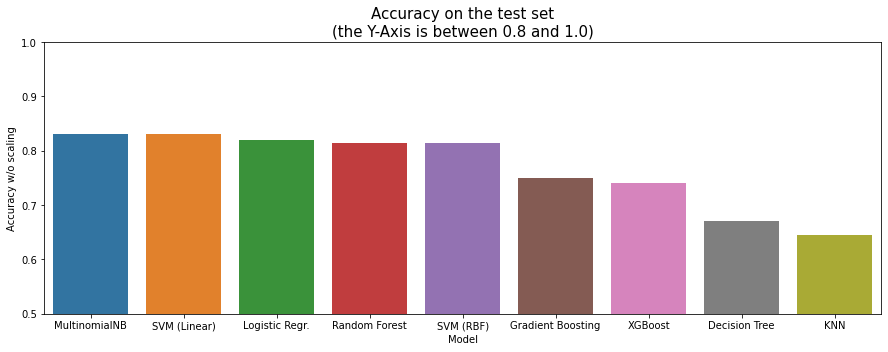

In [48]:
# Bar plot for accuracy
plt.figure(figsize = (15,5))
sns.barplot(x = 'Model', y = 'Accuracy w/o scaling', data = df_acc)
plt.title('Accuracy on the test set\n(the Y-Axis is between 0.8 and 1.0)', fontsize = 15)
plt.ylim(0.5,1)
plt.show()
